<a href="https://colab.research.google.com/github/VitalyGladyshev/med_work/blob/main/PneumothoraxGlVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение пневмоторакса

## Гладышев В.В.

## Импорты

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer

from sklearn.metrics import roc_curve, roc_auc_score

In [30]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.6 MB/s eta 0:00:00


In [31]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm

In [6]:
def classification_metrics(y, pred):
    pre = accuracy_score(y, pred)
    print(f"accuracy score:\t\t{pre:.5f}\n")

    pre = f1_score(y, pred, average="macro")
    print(f"f1 score:\t\t{pre:.5f}")

    pre = precision_score(y, pred, average="macro")
    print(f"precision score:\t{pre:.5f}")

    pre = recall_score(y, pred, average="macro", zero_division=0.0)
    print(f"recall score:\t\t{pre:.5f}")

## Подготовка данных

**SIIM-ACR Pneumothorax Segmentation**<br>
Identify Pneumothorax disease in chest x-rays<br>
https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data


In [1]:
!unzip -q /content/siim-acr-pneumothorax-segmentation.zip

In [16]:
labels = pd.read_csv('/content/stage_2_train.csv')

In [17]:
labels.head()

,Unnamed: 0,ImageId,EncodedPixels
0,420,1.2.276.0.7230010.3.1.4.8323329.3678.151787517...,194329 37 960 69 919 111 913 117 910 116 912 5...
1,9772,1.2.276.0.7230010.3.1.4.8323329.4200.151787518...,-1
2,1542,1.2.276.0.7230010.3.1.4.8323329.4862.151787518...,344265 2 1020 7 1015 9 1012 12 1010 14 1008 15...
3,7532,1.2.276.0.7230010.3.1.4.8323329.12313.15178752...,-1
4,5542,1.2.276.0.7230010.3.1.4.8323329.14214.15178752...,-1


In [18]:
print(f"Всего записей: {labels['ImageId'].count()}, из них уникальных {labels['ImageId'].value_counts().shape[0]}")

Всего записей: 12954, из них уникальных 12047


In [19]:
labels = labels.drop_duplicates('ImageId')

In [20]:
labels.shape

(12047, 3)

In [21]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12047 entries, 0 to 12953
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     12047 non-null  int64 
 1   ImageId        12047 non-null  object
 2   EncodedPixels  12047 non-null  object
dtypes: int64(1), object(2)
memory usage: 376.5+ KB


In [23]:
labels.columns = ['Ind', 'ImageId', 'Target']

In [24]:
labels['Target'][labels['Target'].values != '-1'] = 1
labels['Target'][labels['Target'].values == '-1'] = 0
labels['Target']=labels.Target.astype('int64')

<ipython-input-24-6eb95127e2ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Target'][labels['Target'].values == '-1'] = 0


In [25]:
labels.head()

,Ind,ImageId,Target
0,420,1.2.276.0.7230010.3.1.4.8323329.3678.151787517...,1
1,9772,1.2.276.0.7230010.3.1.4.8323329.4200.151787518...,0
2,1542,1.2.276.0.7230010.3.1.4.8323329.4862.151787518...,1
3,7532,1.2.276.0.7230010.3.1.4.8323329.12313.15178752...,0
4,5542,1.2.276.0.7230010.3.1.4.8323329.14214.15178752...,0


In [32]:
ROOT_PATH = Path("/content/stage_2_images")
SAVE_PATH = Path("/content/Processed/train_or_val/")

In [37]:
all_train_dcm = list(ROOT_PATH.rglob("*.*"))
all_train_dcm[0]

PosixPath('/content/stage_2_images/ID_9190ed1b5.dcm')

In [39]:
all_train_dcm[:5]

[PosixPath('/content/stage_2_images/ID_9190ed1b5.dcm'),
 PosixPath('/content/stage_2_images/ID_344690d36.dcm'),
 PosixPath('/content/stage_2_images/ID_0247eb561.dcm'),
 PosixPath('/content/stage_2_images/ID_e0e3b3cda.dcm'),
 PosixPath('/content/stage_2_images/ID_d6d359ce7.dcm')]

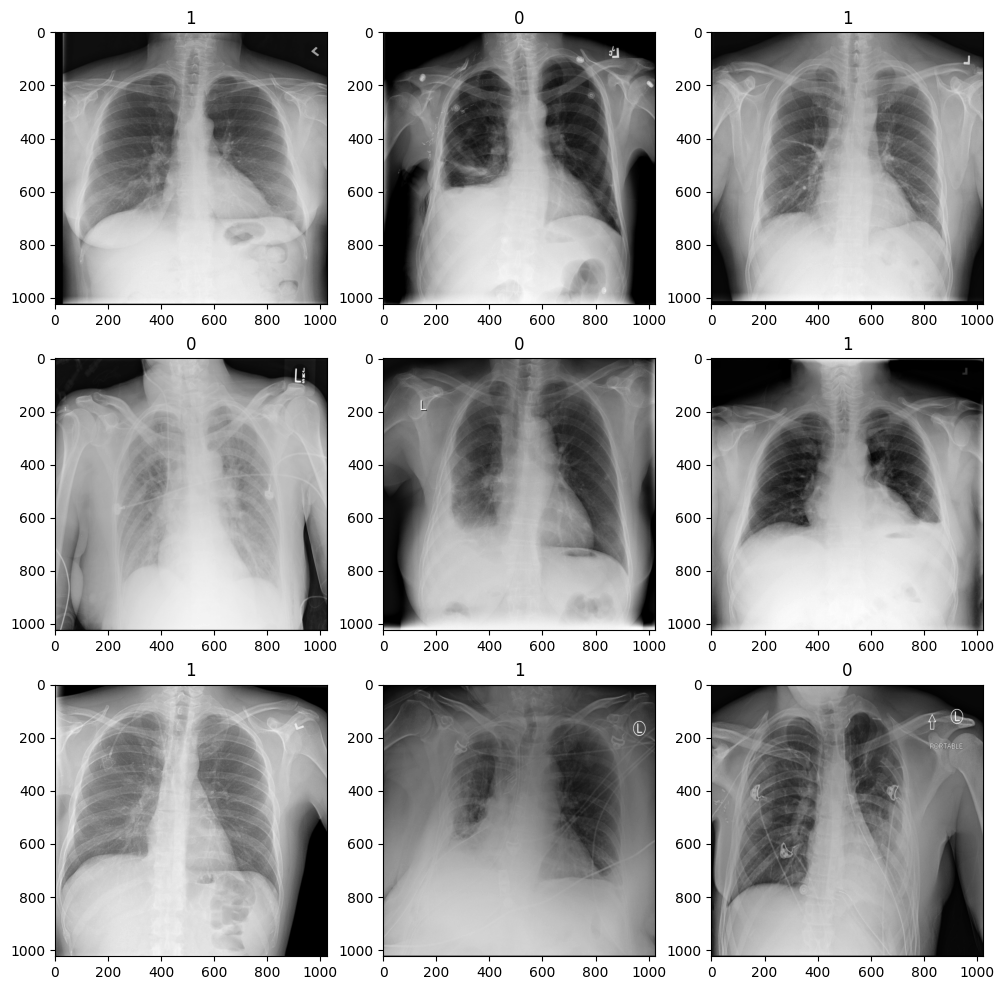

In [40]:
# Для начала создадим объекты fig и axis и используем функцию plt.subplots,
# введем число строк и столбцов, а также зададим размер изображения  12x12
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
# Создадим переменную - счетчик циклов с исходным значением 0
c = 0
# Создадим вложенный цикл: внешний - итерации по строкам, внутренний - по столбцам
for i in range(3):
    for j in range(3):
        # В функцию read_file передаем путь к файлу и получаем массив пикселей dicom файла
        dcm = pydicom.read_file(all_train_dcm[c]).pixel_array

        # Сохраним значение таргета в переменной label
        label = labels['Target'].iloc[c]

        # Воспользуемся функцией imshow для отображения массива пикселей.
        # Значение color map установим 'bone' или 'gray'
        axis[i][j].imshow(dcm, cmap='gray')

        # В качестве заголовка просто установим значение таргета
        axis[i][j].set_title(label)
        # Увеличим значение счетчика
        c+=1

In [44]:
base_dir = "/content/Processed/train_or_val"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Создание датасетов
batch_size = 32
img_size = (224, 224)

train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    label_mode='binary',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## Строим модель

In [45]:
def build_vgg13(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # Первый блок Conv + MaxPooling
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Второй блок Conv + MaxPooling
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Третий блок Conv + MaxPooling
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Четвертый блок Conv + MaxPooling
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Пятый блок Conv + MaxPooling
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), strides=(2, 2)),

        # Полносвязные слои
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),

        # Выходной слой для бинарной классификации
        Dense(1, activation='sigmoid')
    ])

    return model

In [46]:
input_shape = (224, 224, 1)
model = build_vgg13(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,953,793 (491.92 MB)

 Trainable params: 128,953,793 (491.92 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1080s 6s/step - accuracy: 0.7188 - loss: 219.9703 - val_accuracy: 0.6250 - val_loss: 2.5243
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 347ms/step - accuracy: 0.8684 - loss: 0.3069 - val_accuracy: 0.7500 - val_loss: 0.7464
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.8842 - loss: 0.2718 - val_accuracy: 0.8125 - val_loss: 0.5044
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - accuracy: 0.9003 - loss: 0.2307 - val_accuracy: 0.9375 - val_loss: 0.2726
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 347ms/step - accuracy: 0.9132 - loss: 0.2003 - val_accuracy: 1.0000 - val_loss: 0.0415
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 344ms/step - accuracy: 0.9331 - loss: 0.1831 - val_accuracy: 0.9375 - val_loss: 0.1674
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.9203 - loss: 0.2123 - val_accuracy: 1.0000 - val_loss: 0.0460
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - accuracy: 0.9386 - loss: 

# Оценка эффективности модели

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Получение предсказаний для тестового набора
test_dataset = test_dataset.unbatch()
test_images = []
test_labels = []

In [ ]:
for image, label in test_dataset:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
preds = model.predict(test_images)
y_true = test_labels
y_pred = preds.ravel()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step


In [ ]:
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

In [ ]:
# Расчет метрик
accuracy = accuracy_score(y_true, y_pred_class)
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)

In [ ]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.8108974358974359
Precision: 0.8953488372093024
Recall: 0.7897435897435897
F1-score: 0.8392370572207083


In [ ]:
# ROC-кривая и AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)


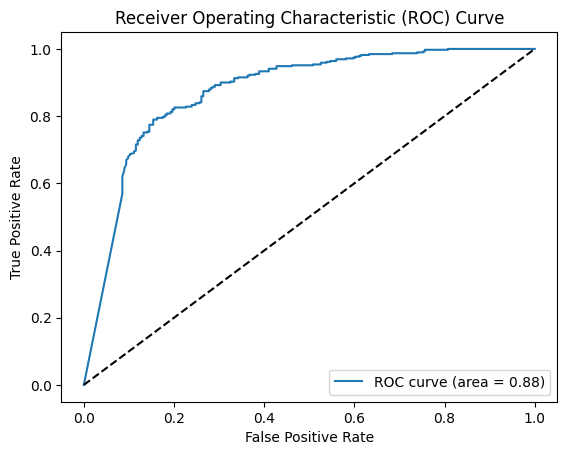

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Определение оптимального порога
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

Optimal threshold: 0.9999730587005615


In [ ]:
# Пример использования порога
y_pred_class = (y_pred >= optimal_threshold).astype(int)

# Выводы


Реализована модель с архитектурой IVGG13

Достигнуты следующие значения метрик
* Accuracy: 0.811
* F1-score: 0.839
* Precision: 0.895
* Recall: 0.79

